In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA


In [21]:
# Load the datasets
customers_df =pd.read_csv(r'C:\Users\Admin\ecommerce_analysis\data\Customers.csv')
products_df = pd.read_csv(r'C:\Users\Admin\ecommerce_analysis\data\Products.csv')
transactions_df = pd.read_csv(r'C:\Users\Admin\ecommerce_analysis\data\Transactions.csv')

In [22]:
# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


In [23]:
# Create customer features for clustering
def create_clustering_features():
    # Transaction features
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean'],
        'TransactionID': 'count'
    }).fillna(0)
    
    # Flatten column names
    transaction_features.columns = ['_'.join(col).strip() for col in transaction_features.columns.values]
    
    # Category preferences
    category_pivot = pd.merge(transactions_df, products_df[['ProductID', 'Category']], on='ProductID')
    category_features = pd.crosstab(category_pivot['CustomerID'], category_pivot['Category'])
    
    # Purchase recency and frequency
    last_purchase = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    first_purchase = transactions_df.groupby('CustomerID')['TransactionDate'].min()
    customer_age = (last_purchase - first_purchase).dt.days
    
    # Combine features
    feature_matrix = pd.concat([
        transaction_features,
        category_features,
        customer_age.rename('customer_age')
    ], axis=1).fillna(0)
    
    return feature_matrix


In [24]:
# Create feature matrix
feature_matrix = create_clustering_features()

In [25]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

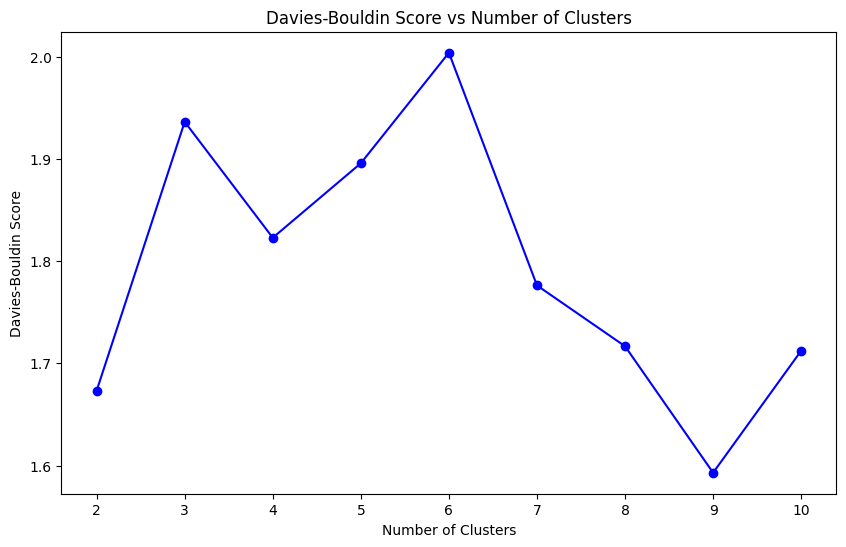

Optimal number of clusters: 9


In [26]:
# Find optimal number of clusters using Davies-Bouldin Index
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, clusters))

# Plot Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, 'bo-')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

# Choose optimal number of clusters (lowest DB score)
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

In [27]:
# Perform final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = final_kmeans.fit_predict(scaled_features)


In [28]:
# Add cluster labels to feature matrix
feature_matrix['Cluster'] = clusters

In [29]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

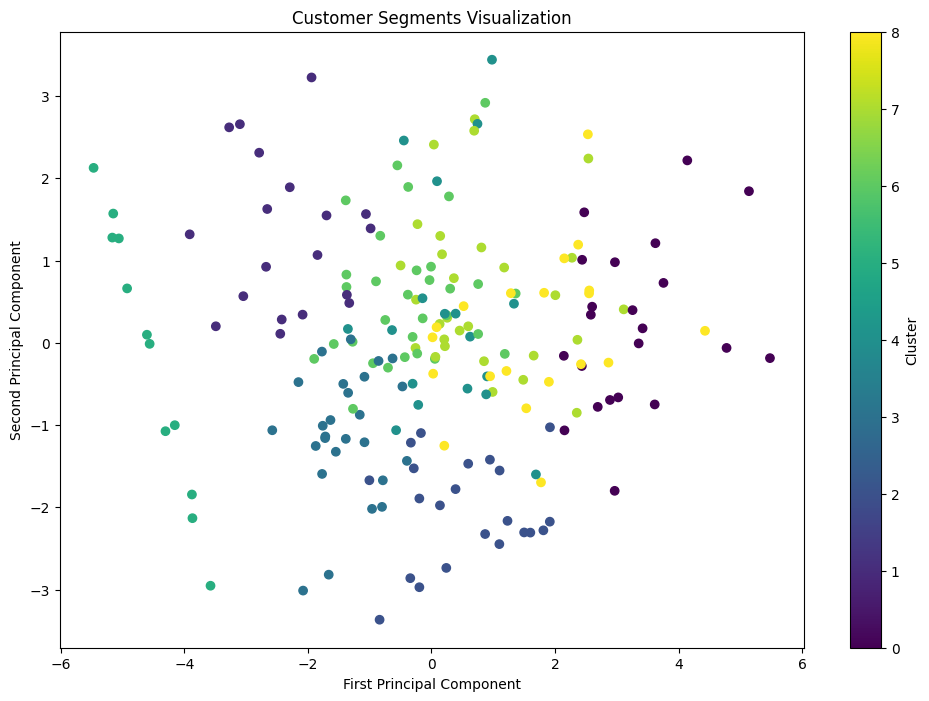

In [30]:
# Create cluster visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [31]:
# Analyze clusters
cluster_stats = feature_matrix.groupby('Cluster').agg({
    'TotalValue_sum': 'mean',
    'TotalValue_mean': 'mean',
    'Quantity_sum': 'mean',
    'TransactionID_count': 'mean',
    'customer_age': 'mean'
}).round(2)

print("\nCluster Statistics:")
print(cluster_stats)


Cluster Statistics:
         TotalValue_sum  TotalValue_mean  Quantity_sum  TransactionID_count  \
Cluster                                                                       
0               6470.05           797.40         23.05                 8.23   
1               1355.95           395.17          6.58                 3.47   
2               4471.81          1062.94         13.55                 4.27   
3               2293.94           769.36          8.12                 3.00   
4               3401.22           666.22         12.11                 5.33   
5                528.41           528.41          2.33                 1.00   
6               2732.36           564.44         11.68                 4.90   
7               3982.46           642.46         14.52                 6.28   
8               4805.57           696.37         18.35                 6.95   

         customer_age  
Cluster                
0              282.27  
1              187.21  
2            

In [32]:
# Save clustering results
clustering_results = pd.DataFrame({
    'CustomerID': feature_matrix.index,
    'Cluster': clusters
})
clustering_results.to_csv('clustering_results.csv', index=False)

# Calculate and display final DB Index
final_db_index = davies_bouldin_score(scaled_features, clusters)
print(f"\nFinal Davies-Bouldin Index: {final_db_index:.4f}")


Final Davies-Bouldin Index: 1.5930


In [39]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)

# Calculate Calinski-Harabasz Score
ch_score = calinski_harabasz_score(scaled_features, clusters)

# Calculate cluster cohesion (within-cluster sum of squares)
cohesion = final_kmeans.inertia_

# Calculate separation (between-cluster sum of squares)
cluster_centers = final_kmeans.cluster_centers_
separation = 0
for i in range(len(cluster_centers)):
    for j in range(i + 1, len(cluster_centers)):
        separation += np.sum((cluster_centers[i] - cluster_centers[j]) ** 2)

# Print all evaluation metrics
print("\nClustering Evaluation Metrics:")
print(f"Davies-Bouldin Index: {final_db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")
print(f"Within-cluster Sum of Squares (Cohesion): {cohesion:.4f}")
print(f"Between-cluster Sum of Squares (Separation): {separation:.4f}")

# Calculate explained variance ratio from PCA
total_variance_explained = sum(pca.explained_variance_ratio_) * 100
print(f"\nTotal Variance Explained by PCA: {total_variance_explained:.2f}%")

# Calculate cluster stability
cluster_sizes = pd.Series(clusters).value_counts()
cluster_stability = (cluster_sizes / len(clusters)).round(4)
print("\nCluster Stability (Size Distribution):")
print(cluster_stability)

# Calculate overall clustering quality score
# Normalize scores to 0-1 range for combination
normalized_silhouette = (silhouette_avg + 1) / 2  # Silhouette is already -1 to 1
normalized_db = 1 / (1 + final_db_index)  # Convert DB index to 0-1 where higher is better
normalized_ch = ch_score / (ch_score + 100)  # Normalize CH score

# Combine scores with equal weights
overall_quality = (normalized_silhouette + normalized_db + normalized_ch) / 3 * 100

print(f"\nOverall Clustering Quality Score: {overall_quality:.2f}%")


Clustering Evaluation Metrics:
Davies-Bouldin Index: 1.5930
Silhouette Score: 0.1382
Calinski-Harabasz Score: 29.7393
Within-cluster Sum of Squares (Cohesion): 971.9471
Between-cluster Sum of Squares (Separation): 589.3086

Total Variance Explained by PCA: 56.31%

Cluster Stability (Size Distribution):
6    0.1558
7    0.1457
3    0.1307
2    0.1106
0    0.1106
8    0.1005
1    0.0955
4    0.0905
5    0.0603
Name: count, dtype: float64

Overall Clustering Quality Score: 39.47%
